# MC920 - Trabalho 1

Rafael Sartori M. Santos, 186154

## Problema

Aplicar técnicas de meios-tons com difusão de erros de forma a alterar os níveis de cinza das imagens dadas.

## Organização

* Trecho comum a todo código (funções auxiliares para salvar, mostrar imagens);
* Aplicações de técnicas diferentes em todo conjunto de imagem.

#### Observação:

Para executar corretamente todos os programas, é necessário executar o código inicial comum a todas as soluções.

## Soluções

Utilizarei `matplotlib` para imprimir imagens no relatório, `numpy` para executar as transformações de forma otimizada, interface OpenCV (`cv2` para Python) para abrir e salvar imagens no formato desejado, `glob` e `os` (padrão de Python) para trabalhar com as pastas e arquivos, automatizando o processo de aplicação de filtro a todas as imagens dadas.

### Trecho comum

Aqui definimos as funções e variáveis auxiliares ao resto do programa. São elas:

* `salvar_imagem(caminho, pasta, imagem)`: função, salva a imagem em uma nova pasta dado caminho original;
* `mostrar_imagens(imagem_original, imagem_alterada)`: função, mostra imagem original e alterada lado a lado no Notebook;
* `imagens`: variável global, dicionário cuja chave é o caminho da imagem original e valor, a imagem.

In [17]:
from matplotlib import pyplot as plt # para gráficos e imagens
import numpy as np # numpy para transformações
import glob # para abrir todos os PNGs da pasta ../Imagem/
import cv2 # OpenCV para lidar com imagens
import os # para criar pasta de saída de imagens


# Variáveis de configuração
CAMINHO_IMAGEM = '../Imagens/'
TAMANHO_IMAGEM = 3.6


## Carregamos todas as imagens num dicionário
## Chave = caminho da imagem
## Valor = imagem
imagens = {}
# Para todas as imagens da pasta dada...
for caminho in glob.glob('{0}*.png'.format(CAMINHO_IMAGEM)):
    # Carregamos imagem utilizando OpenCV
    imagem = cv2.imread(caminho, cv2.IMREAD_UNCHANGED)
    # Guardamos no dicionário com o caminho original
    # (para salvarmos depois)
    imagens[caminho] = imagem
    

## Função para salvar a imagem
## Caminho da imagem original
def salvar_imagem(caminho, pasta, imagem):
    # Garantimos que o diretório existe
    try:
        os.makedirs(pasta)
    except FileExistsError:
        pass
    # Utilizamos OpenCV para salvar imagem no novo caminho
    cv2.imwrite(caminho.replace(CAMINHO_IMAGEM, pasta), imagem)

    
## Função para mostrar imagem utilizando matplotlib
def mostrar_imagens(imagem_original, imagem_alterada):
    # Criamos espaço para duas figuras quadradas
    figura = plt.figure(figsize=[TAMANHO_IMAGEM*2, TAMANHO_IMAGEM])
    rows, columns = (1, 2)
    # Adicionamos a original a esquerda
    subplot = figura.add_subplot(rows, columns, 1)
    plt.imshow(imagem_original, cmap='gray', interpolation='bicubic')
    # Deixamos de mostrar as coordenadas
    plt.xticks([])
    plt.yticks([])
    plt.title('Imagem original')
    # Adicionamos a alterada a direita
    subplot = figura.add_subplot(rows, columns, 2)
    plt.imshow(imagem_alterada, cmap='gray', interpolation='bicubic')
    # Deixamos de mostrar as coordenadas
    plt.xticks([])
    plt.yticks([])
    plt.title('Imagem alterada')
    # Mostramos a figura final
    plt.show()

### Método geral

Para produzir meios-tons utilizando difusão de erro, fazemos:
* Inicializamos uma imagem de saída de mesma dimensão que a original
* Percorremos as linhas de forma zigue-zague (da esq. para dir. nas linhas pares, da dir. para esq. nas linhas ímpares)
    * Percorremos as colunas fazendo o meio-tom (se o valor é superior à intensidade média da profundidade da imagem, definimos como branco, caso contrário, preto)
    * Disseminamos a diferença entre a imagem original e o que atribuímos (preto ou branco) aos pontos vizinhos de acordo com o filtro de nossa escolha

Definimos aqui, então, a função que aplica o filtro: `aplicar_filtro(filtro, caminho_salvar)`. Com um detalhe, porém: como utilizamos uma matriz de pares ordenados para indicar a posição relativa para disseminar o erro, precisamos criá-la a partir do filtro.

Por exemplo, para este filtro:
```
filtro = [[0, '*', 1/4],
          [1/4, 1/4, 1/4]]
```
precisamos desta matriz de posições, que utiliza o asterisco para indicar o centro do filtro:
```
filtro_pos = [[(-1, 0), (0, 0), (1, 0)],
              [(-1, 1), (0, 1), (1, 1)]]
```

In [70]:
def aplicar_filtro(filtro, caminho_salvar):
    primeira = True
    
    # Determinamos o tamanho do filtro, pois não é vetor de numpy
    linhas, colunas = (len(filtro), len(filtro[0]))
    # Inicializamos a matriz `filtro_pos`
    filtro_pos = []
    # Encontramos o asterisco percorrendo a matriz
    # Obs: já iniciamos filtro_pos com suas linhas
    asterisco = None
    for y_ast in range(0, linhas):
        filtro_pos.append([])
        # Continuamos procurando
        for x_ast in range(0, colunas):
            if filtro[y_ast][x_ast] == '*':
                asterisco = (x_ast, y_ast)
                filtro[y_ast][x_ast] = 0
    # Conferimos sua existência
    if asterisco is None:
        raise Exception('Asterisco não encontrado em filtro!')
    # Produzimos a matriz `filtro_pos`
    for y in range(0, linhas):
        for x in range(0, colunas):
            filtro_pos[y].append((x - asterisco[0], y - asterisco[1]))
    
    # Convertemos o filtro agora que não possui asteriscos
    filtro = np.asarray(filtro)
    
    # Para cada imagem...
    for caminho, imagem in imagens.items():
        # Carregamos a imagem em um vetor numpy
        img = np.array(imagem)
        # Produzimos uma imagem para saída
        saida = np.zeros(img.shape)

        # Para cada linha...
        for y in range(0, img.shape[0]):
            # Em linhas pares, vamos da esquerda para direita em coluna
            intervalo = range(0, img.shape[1])
            # Em linhas ímpares, da direita para esquerda em coluna
            if y % 2 == 1:
                intervalo = reversed(intervalo)

            # Para cada coluna...
            for x in intervalo:
                # Aplicamos o meio-tom
                if img[y][x] >= 128:
                    saida[y][x] = 1
                else:
                    saida[y][x] = 0

                # Aplicamos a difusão de erro de acordo com a regra do filtro
                erro = img[y][x] - (saida[y][x] * 255)
                # Para cada posição do filtro
                for y_ in range(0, filtro.shape[0]):
                    for x_ in range(0, filtro.shape[1]):
                        dx, dy = filtro_pos[y_][x_]
                        # Pulamos posições inválidas
                        if ((x + dx) >= img.shape[1] or (x + dx) < 0):
                            continue
                        if ((y + dy) >= img.shape[0] or (y + dy) < 0):
                            continue
                        # Aplicamos a difusão de erro com o filtro
                        img[y + dy][x + dx] += erro * filtro[y_][x_]


        # Salvamos as imagens
        salvar_imagem(caminho, caminho_salvar, saida * 255)

        # Se é a primeira imagem, mostramos o antes e depois
        if primeira:
            primeira = False
            mostrar_imagens(imagem, saida)

#### Filtro Floyd e Steinberg

Definimos o filtro:
```
filtro = [[0, '*', 7/16],
          [3/16, 5/16, 1/16]]
```
onde o asterisco é o centro e aplicamos às imagens.

[[0, 0, 0.4375], [0.1875, 0.3125, 0.0625]]
[[0.     0.     0.4375]
 [0.1875 0.3125 0.0625]]


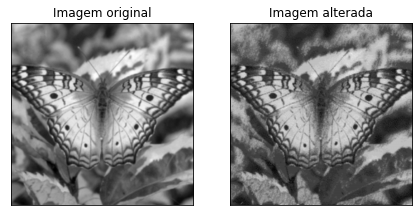

In [71]:
# Definimos o filtro
filtro = [[0, '*', 7/16],
          [3/16, 5/16, 1/16]]

aplicar_filtro(filtro, '1.floyd-steinberg/')

#### Filtro Stevenson e Arce

Definimos o filtro:
```
filtro = [[0, 0, 0, '*', 0, 32/200, 0],
          [12/200, 0, 26/200, 0, 30/200, 0, 16/200],
          [0, 12/200, 0, 26/200, 0, 12/200, 0],
          [5/200, 0, 12/200, 0, 12/200, 0, 5/200]]

```
onde o asterisco é o centro e aplicamos às imagens.

In [ ]:
# Definimos o filtro
filtro = [[0, 0, 0, '*', 0, 32/200, 0],
          [12/200, 0, 26/200, 0, 30/200, 0, 16/200],
          [0, 12/200, 0, 26/200, 0, 12/200, 0],
          [5/200, 0, 12/200, 0, 12/200, 0, 5/200]]

aplicar_filtro(filtro, '2.stevenson-arce/')

#### Filtro Burkes

Definimos o filtro:
```
filtro = [[0, 0, '*', 8/32, 4/32],
          [2/32, 4/32, 8/32, 4/32, 2/32]]
```
onde o asterisco é o centro e aplicamos às imagens.

In [ ]:
# Definimos o filtro
filtro = [[0, 0, '*', 8/32, 4/32],
          [2/32, 4/32, 8/32, 4/32, 2/32]]

aplicar_filtro(filtro, '3.burkes/')

#### Filtro Sierra

Definimos o filtro:
```
filtro = [[0, 0, '*', 5/32, 3/32],
          [2/32, 4/32, 5/32, 4/32, 2/32],
          [0, 2/32, 3/32, 2/32, 0]]
```
onde o asterisco é o centro e aplicamos às imagens.

In [ ]:
# Definimos o filtro
filtro = [[0, 0, '*', 5/32, 3/32],
          [2/32, 4/32, 5/32, 4/32, 2/32],
          [0, 2/32, 3/32, 2/32, 0]]

aplicar_filtro(filtro, '4.sierra/')

#### Filtro Stucki

Definimos o filtro:
```
filtro = [[0, 0, '*', 8/42, 4/42],
          [2/42, 4/42, 8/42, 4/42, 2/42],
          [1/42, 2/42, 4/42, 2/42, 1/42]]
```
onde o asterisco é o centro e aplicamos às imagens.

In [ ]:
# Definimos o filtro
filtro = [[0, 0, '*', 8/42, 4/42],
          [2/42, 4/42, 8/42, 4/42, 2/42],
          [1/42, 2/42, 4/42, 2/42, 1/42]]

aplicar_filtro(filtro, '5.stucki/')

#### Filtro Jarvis, Judice e Ninke

Definimos o filtro:
```
filtro = [[0, 0, '*', 8/42, 4/42],
          [2/42, 4/42, 8/42, 4/42, 2/42],
          [1/42, 2/42, 4/42, 2/42, 1/42]]
```
onde o asterisco é o centro e aplicamos às imagens.

In [ ]:
# Definimos o filtro
filtro = [[0, 0, '*', 7/48, 5/48],
          [3/48, 5/48, 7/48, 5/48, 3/48],
          [1/48, 3/48, 5/48, 3/48, 1/48]]

aplicar_filtro(filtro, '6.jarvis-judice-ninke/')